In [1]:
import pandas as pd
import numpy as np
import pyvista as pv
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from dash import Dash, html, dcc
import plotly.express as px
import plotly.graph_objects as go

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In this notebook, you should apply the techniques you learned for regression in a more realistic problem setting. We have a collection of bridges, which are modelled as 2D-beams, that all feature one defect. Our goal is to train a model to learn the location of this defect as a function of displacement measurements. Since sensors are expensive, we can only place them in five locations of the bridges. The assignments includes the following tasks:
- Select five locations for the sensors based on a visual inspection of the displacement field <!--, and extract the displacement measurements from the dataset -->
<!-- - Extract the defect location from the individual bridges-->
- Train a neural network to learn a mapping from the displacement measurements to the defect location, comment on the choice of hyperparameters (number of hidden layers, nodes per layer, ...)
- Visualise your results and evaluate the accuracy of your network

Let's take a look at the dataset first. It is csv-file, and a convenient way to read and manipulate this filetype is via the `Dataframe` of the `pandas` library. It is good practice to print a few lines of the dataset before performing the analysis. We load the dataset into a `Dataframe` from the `pandas` library and print a few rows from the top and bottom. The dataset consists of a collection of displacement fields of the bridges. We have total of 1000 bridges, as can be seen from the tail of the dataframe `df.tail()`, and 712 locations in which the displacements have been measures, as can be seen from the tail of a sample `bar_0.tail()`, which is just a single sample we took from the dataset. Note that some of the columns, such as E_pure, nu, and location, are uniform for a specific sample owed to the structure of the dataset.

In [2]:
df = pd.read_csv('regression-data.csv')
bar_0 = df[df['sample'] == 0]
df.head()

,sample,E_pure,nu,deteriorations,location,node,x,y,dx,dy,E_true
0,0,10000.0,0.2,1,7.063183,0,0.0,0.0,0.000000,0.000000,10000.000000
1,0,10000.0,0.2,1,7.063183,1,10.0,0.0,0.028953,0.000000,9998.301731
2,0,10000.0,0.2,1,7.063183,2,10.0,2.0,0.002377,-0.005370,9998.301731
3,0,10000.0,0.2,1,7.063183,3,5.0,2.0,0.014410,-0.046229,9987.432772
4,0,10000.0,0.2,1,7.063183,4,0.0,2.0,0.026353,-0.005033,10000.000000


In [3]:
df.tail()

,sample,E_pure,nu,deteriorations,location,node,x,y,dx,dy,E_true
712995,999,10000.0,0.2,1,1.494755,708,9.889581,0.110419,0.026034,-0.003915,10000.000000
712996,999,10000.0,0.2,1,1.494755,709,9.889581,1.889581,0.003770,-0.006701,10000.000000
712997,999,10000.0,0.2,1,1.494755,710,5.221090,1.118279,0.014272,-0.046419,9999.841238
712998,999,10000.0,0.2,1,1.494755,711,1.492172,0.111827,0.004598,-0.023698,9892.946374
712999,999,10000.0,0.2,1,1.494755,712,4.809589,0.343110,0.013898,-0.046286,9999.478980


In [4]:
bar_0.tail()

,sample,E_pure,nu,deteriorations,location,node,x,y,dx,dy,E_true
708,0,10000.0,0.2,1,7.063183,708,9.889581,0.110419,0.026053,-0.003920,9997.864571
709,0,10000.0,0.2,1,7.063183,709,9.889581,1.889581,0.003715,-0.006708,9997.858176
710,0,10000.0,0.2,1,7.063183,710,5.221090,1.118279,0.014258,-0.046496,9971.220630
711,0,10000.0,0.2,1,7.063183,711,1.492172,0.111827,0.004574,-0.023654,9999.999979
712,0,10000.0,0.2,1,7.063183,712,4.809589,0.343110,0.013850,-0.046345,9989.634516


Your first task is to select measurement locations. The following cell plots the displacement in x- or y-direction, or its magnitude of the beam. You can select the three components via the dropdown menu on the topside. In addition, you can see all the available measurement locations. You can hover over the plot, it will display the corresponding node ID of the dataframe.

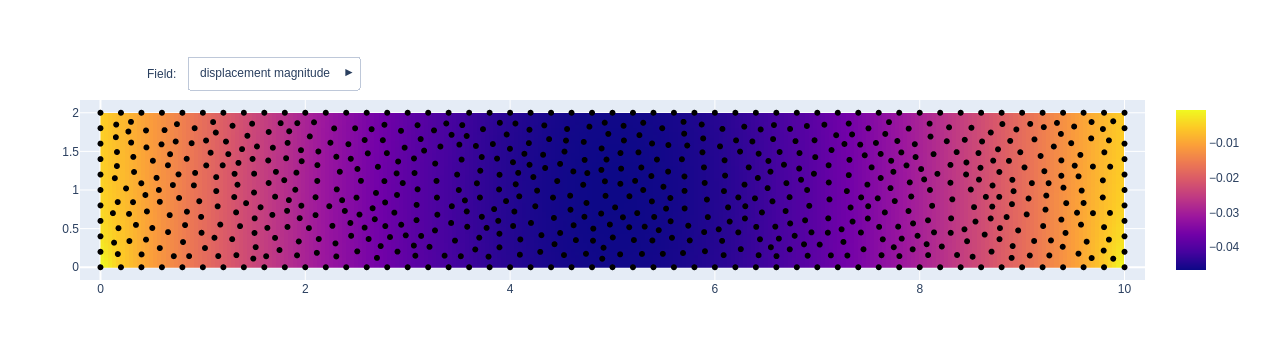

In [165]:


# extract data corresponding to one single bridge, an interpolate the displacements on a grid for plotting
bar_0 = df[df['sample'] == 0]
grid_x, grid_y = np.mgrid[0.02:9.98:250j, 0.02:1.98:50j]
grid_z = griddata(bar_0[['x','y']].to_numpy(), bar_0['dy'], (grid_x, grid_y))
# grid_z = griddata(bar_0[['x','y']].to_numpy(), np.sqrt(bar_0['dx']**2 + bar_0['dy']**2), (grid_x, grid_y))

# plot displacement-field and nodes
fig = go.Figure()
fig.add_trace(go.Heatmap(z=grid_z.transpose(),
                         x=grid_x[:,0],
                         y=grid_y[0],
                         hoverinfo='skip',
                         name='heatmap'))

fig.add_trace(go.Scatter(x=bar_0['x'],
                         y=bar_0['y'],
                         mode='markers',
                         marker_color='black',
                         name='',
                         hovertemplate='<b>Node</b>: %{text}',
                         text=bar_0['node']))

fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=["z", [griddata(bar_0[['x','y']].to_numpy(), np.sqrt(bar_0['dx']**2 + bar_0['dy']**2), (grid_x, grid_y)).transpose()]],
                    label="displacement magnitude",
                    method="restyle"
                ),
                dict(
                    args=["z", [griddata(bar_0[['x','y']].to_numpy(), bar_0['dx'], (grid_x, grid_y)).transpose()]],
                    label="displacement x",
                    method="restyle"
                ),
                dict(
                    args=["z", [griddata(bar_0[['x','y']].to_numpy(), bar_0['dy'], (grid_x, grid_y)).transpose()]],
                    label="displacement y",
                    method="restyle"
                )
            ]),
            direction="right",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.3,
            yanchor="top"
        ),
    ]
)

# Add annotation
fig.update_layout(
    annotations=[
        dict(text="Field:", showarrow=False,
        x=0.6, y=1.2, yref="paper", align="left")
    ]
)

fig.update_xaxes(range=(-0.2,10.2), constrain='domain')
# fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
fig.show()
# fig.to_dict()

Select five measument location which you expect to be informative. Plug them into the predefined list `measure_locs`. Remeber that we only have a budget of five locations, make sure to not exceed this threshold to get the full amount of points for this exercise. The remaining code in this cell collects the displacements from all of our beams at the selected nodes, as well as the defect location. These quantities are stored in the arrays `measurements` and `defect_locs`.

In [6]:
# define measurement locations, get corresponding coord
measure_locs = [481, 461, 312, 41, 66]
measure_coords = np.array([bar_0[bar_0['node'] == loc][['x','y']].to_numpy() for loc in measure_locs]).squeeze(1)

# double check the measurement locations
print(measure_coords)
                             
# read measurement from all samples in dataframe
measurements = np.empty((df['sample'].max()+1,0))

# loop through measurement locations and collect measuments from all samples
for loc in measure_locs:
    dx = df[df['node'] == loc]['dx'].to_numpy()
    dy = df[df['node'] == loc]['dy'].to_numpy()
    measurements = np.append(measurements, np.vstack((dx, dy)).transpose(),axis=1)
    
measurements_noisy = measurements + np.random.randn(*measurements.shape) * .5e-5

# get defect locations
defect_locs = df[df['node']==0]['location'].to_numpy()

[[0.65990236 0.45508749]
 [2.12785249 1.49846331]
 [5.0767225  1.08026035]
 [7.4        0.        ]
 [9.2        2.        ]]


Let's plot the defect location as a function of the displacement measurements to get a feel for the dataset:

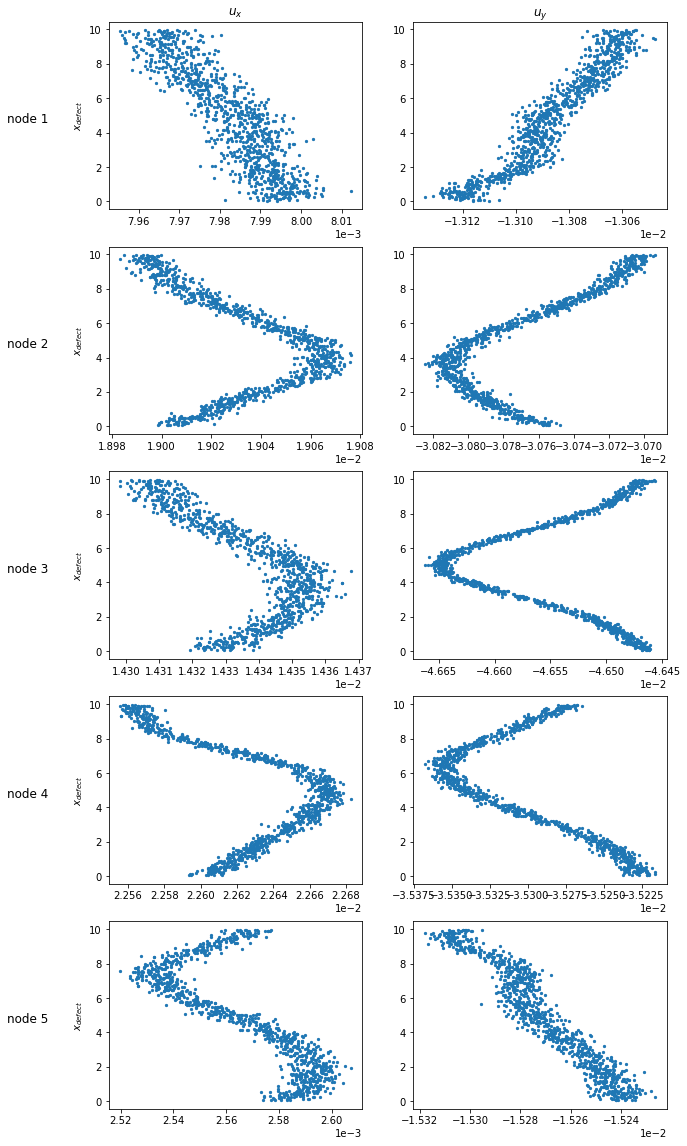

In [7]:
# plot a few hyperplanes of the dataset
fig, ax = plt.subplots(5,2, figsize=(10,20))
[ax.flat[i].scatter(measurements_noisy[:,i], defect_locs, s=5) for i in range(len(ax.flat))]
[ax.flat[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0)) for i in range(len(ax.flat))]
[ax[0,i].set_title(title) for i,title in enumerate([r'$u_x$',r'$u_y$'])]
[ax[i,0].text(-0.4, 0.46, r'node {}'.format(i+1), transform=ax[i,0].transAxes, fontsize=12) for i in range(ax.shape[0])]
[ax[i,0].set_ylabel(r'$x_{defect}$') for i in range(ax.shape[0])]
plt.show()

We can see that most of the measurements do not have a unique mapping to the defect location, suggesting we need more features to distinguish between the deformation states. Let's look at a 2D scatterplot  of our data. The colorbar indicates the defect location of a datapoint. This looks more promosing, the defect location seems to be a injective function when condidereing multiple measurements.

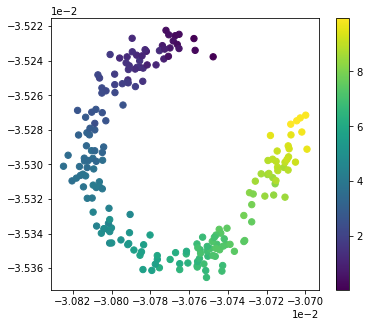

In [166]:
fig, ax = plt.subplots(figsize=(6,5))
plot1 = ax.scatter(measurements_noisy[::5,3], measurements_noisy[::5,7], c=defect_locs[::5], s=40)
[ax.ticklabel_format(style='sci', axis=axis, scilimits=(0,0)) for axis in ['x','y']]
fig.colorbar(plot1)
plt.show()

In [217]:
# function to train the NN
def NN_train(NN, X_train, y_train, X_val, y_val, max_iter=10000, tol=1e-6, verbose=False):
    
    # set up array for mse and improvement count for early stopping
    rmse = np.empty(1)
    no_improvement_count = 0
    
    # loop over iterations
    for i in range(max_iter):
        
        # train for one epoch, compute rmse on validation set
        NN.partial_fit(X_train, y_train)
        rmse = np.hstack( ( rmse, [np.sqrt(np.sum((y_val - NN.predict(X_val))**2))] ) )
        
        # check if no improvement occured in last iter
        if rmse[-1] > rmse[-(no_improvement_count+1)]:
            no_improvement_count += 1
        else:
            no_improvement_count = 0
        
        # exit loop when no improvement was registered during past five iters
        if (no_improvement_count == 5):
            break
        
        # print loss (optional)
        if verbose and i%200==0:
            print("Iteration {}".format(i))
            print("   rmse {:.4e}\n".format(rmse[i]))
    
    # return trained network and last rmse
    return NN, rmse[-1]

In [229]:
# set random seed
np.random.seed(1)

# set up scalers and scale data
xscaler, yscaler = StandardScaler(), StandardScaler()
yit = yscaler.inverse_transform
xit = xscaler.inverse_transform
X, y = xscaler.fit_transform(measurements_noisy), yscaler.fit_transform(defect_locs[:,None]).reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5)

# Set up NN
NN = MLPRegressor(solver='sgd', hidden_layer_sizes=(10,10), activation='tanh')

# train NN
NN,_ = NN_train(NN, X_train, y_train, X_val, y_val, max_iter=10000, verbose=False)

In [230]:
NN

MLPRegressor(activation='tanh', hidden_layer_sizes=(10, 10), solver='sgd')

In [231]:
# # set random seed
# np.random.seed(1)

# # set up scalers and scale data
# xscaler, yscaler = StandardScaler(), StandardScaler()
# yit = yscaler.inverse_transform
# xit = xscaler.inverse_transform
# X, y = xscaler.fit_transform(measurements_noisy), yscaler.fit_transform(defect_locs[:,None]).reshape(-1)
# X_train, X_test, y_train, y_test = train_test_split(X, y)

# # get NN
# NN1 = MLPRegressor(solver='adam', hidden_layer_sizes=(20,20,20), activation='tanh', max_iter=10000, verbose=False, tol=1e-6)

# # train NN
# NN1.fit(X_train,y_train)

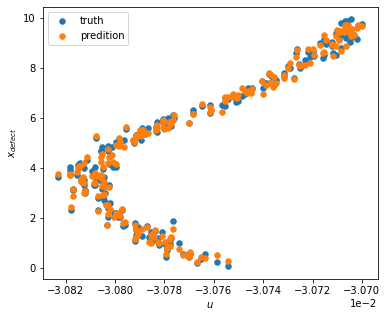

In [232]:
# y_pred = NN.predict(X_test)
y_pred = NN.predict(X_test)
fig, ax = plt.subplots(figsize = (6,5))
loc = 3
ax.scatter(xit(X_test)[:,loc], yit(y_test[:,None]).reshape(-1), label='truth', s=30)
ax.scatter(xit(X_test)[:,loc], yit(y_pred[:,None]).reshape(-1), label='predition', s=30)
ax.legend()
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_xlabel(r'$u$')
ax.set_ylabel(r'$x_{defect}$')
plt.show()

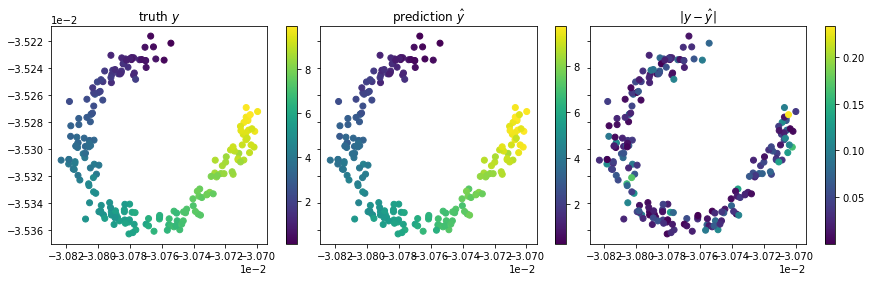

In [233]:
fig, ax = plt.subplots(1,3,figsize=(12,3.8), constrained_layout=True, sharey=True)
plot0 = ax[0].scatter(xit(X_test)[:,3], xit(X_test)[:,7], c=yit(y_test[:,None]).reshape(-1))
plot1 = ax[1].scatter(xit(X_test)[:,3], xit(X_test)[:,7], c=yit(y_pred[:,None]).reshape(-1))
plot2 = ax[2].scatter(xit(X_test)[:,3], xit(X_test)[:,7], c=np.abs(y_pred-y_test))
[plt.colorbar(plot, ax=ax[i]) for i, plot in enumerate([plot0, plot1, plot2])]
[ax[i].set_title(title) for i, title in enumerate([r'truth $y$', r'prediction $\hat y$', r'$|y - \hat y|$'])]
[axs.ticklabel_format(style='sci', axis=axis, scilimits=(0,0)) for axis in ['x','y'] for axs in ax]
plt.show()

The network's performance looks good on a visual inspection, but we need to quantify the error and compare it for different architectures to find the best performing model. For this purpose, we turn to a gridsearch strategie to find hyperparameters that give the best prediction on a validation set.

In [234]:
# define coordinate vectors for grid
layer_sizes = [5,10, 15, 20]
# layer_sizes = [5]
layer_numbers = [1, 2, 3, 4]
# layer_numbers = [1]

# get grid for the coordinate pairs and store them in an array
architectures = np.array([array.flatten() for array in np.meshgrid(layer_sizes, layer_numbers)]).transpose()
rmse = np.empty(architectures.shape[0])

# loop over all pairs
for i, arch in enumerate(architectures):
    
    # get tuple for architecture and print
    layers = (arch[0],) * arch[1]
    print("Training NN with hidden layers:  {}".format(layers))
    
    # get NN
    # NN = MLPRegressor(solver='adam', hidden_layer_sizes=layers, activation='tanh', max_iter=10000, verbose=False, tol=1e-6, validation_fraction=0.0)
    # NN = MLPRegressor(solver='adam', hidden_layer_sizes=layers, activation='tanh', max_iter=10000, verbose=False, tol=1e-6, validation_fraction=0.0)
    NN = MLPRegressor(solver='sgd', hidden_layer_sizes=layers, activation='tanh')
    NN, rmse[i] = NN_train(NN, X_train, y_train, X_val, y_val, max_iter=10000, verbose=False)
    
    # compute rmse and print
    # rmse[i] = np.sqrt(np.sum((y_test - NN.predict(X_test))**2))
    print("     Mean square error:    {:.4e}\n".format(rmse[i]))


# get NN that gave lowerst rmse and print
min_loc = np.argmin(rmse)
print("\n\nModel with {} layers and {} neurons per layer gave lowest rmse of {:.4e}".format(architectures[min_loc,1], architectures[min_loc,0], rmse[min_loc]))

Training NN with hidden layers:  (5,)
     Mean square error:    1.0023e+00

Training NN with hidden layers:  (10,)
     Mean square error:    8.9985e-01

Training NN with hidden layers:  (15,)
     Mean square error:    8.4524e-01

Training NN with hidden layers:  (20,)
     Mean square error:    8.4319e-01

Training NN with hidden layers:  (5, 5)
     Mean square error:    1.0954e+00

Training NN with hidden layers:  (10, 10)
     Mean square error:    8.6077e-01

Training NN with hidden layers:  (15, 15)
     Mean square error:    7.2789e-01

Training NN with hidden layers:  (20, 20)
     Mean square error:    7.4179e-01

Training NN with hidden layers:  (5, 5, 5)
     Mean square error:    7.9300e-01

Training NN with hidden layers:  (10, 10, 10)
     Mean square error:    8.0867e-01

Training NN with hidden layers:  (15, 15, 15)
     Mean square error:    7.3152e-01

Training NN with hidden layers:  (20, 20, 20)
     Mean square error:    7.6934e-01

Training NN with hidden layers

Let's use our test data for visualization purpose of our best performing model, and to test its predictive capabilities.

In [240]:
# Set up NN
layers = (architectures[min_loc, 0],) * architectures[min_loc,1]
NN = MLPRegressor(solver='sgd', hidden_layer_sizes=layers, activation='tanh')

# train NN
NN,_ = NN_train(NN, X_train, y_train, X_val, y_val, max_iter=10000, verbose=False)

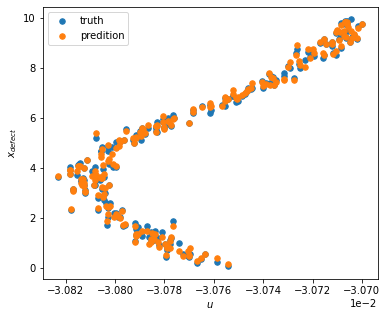

In [241]:
# y_pred = NN.predict(X_test)
y_pred = NN.predict(X_test)
fig, ax = plt.subplots(figsize = (6,5))
loc = 3
ax.scatter(xit(X_test)[:,loc], yit(y_test[:,None]).reshape(-1), label='truth', s=30)
ax.scatter(xit(X_test)[:,loc], yit(y_pred[:,None]).reshape(-1), label='predition', s=30)
ax.legend()
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_xlabel(r'$u$')
ax.set_ylabel(r'$x_{defect}$')
plt.show()

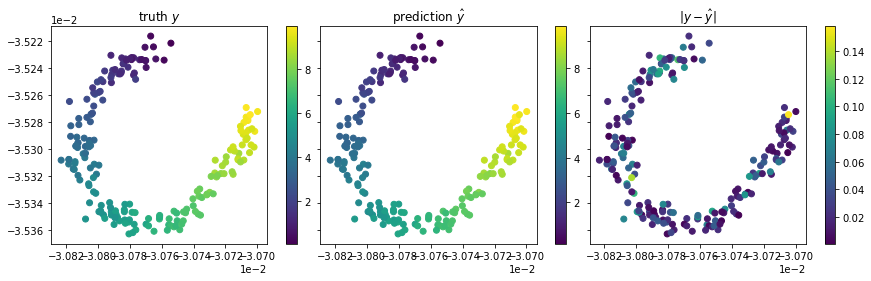

In [242]:
fig, ax = plt.subplots(1,3,figsize=(12,3.8), constrained_layout=True, sharey=True)
plot0 = ax[0].scatter(xit(X_test)[:,3], xit(X_test)[:,7], c=yit(y_test[:,None]).reshape(-1))
plot1 = ax[1].scatter(xit(X_test)[:,3], xit(X_test)[:,7], c=yit(y_pred[:,None]).reshape(-1))
plot2 = ax[2].scatter(xit(X_test)[:,3], xit(X_test)[:,7], c=np.abs(y_pred-y_test))
[plt.colorbar(plot, ax=ax[i]) for i, plot in enumerate([plot0, plot1, plot2])]
[ax[i].set_title(title) for i, title in enumerate([r'truth $y$', r'prediction $\hat y$', r'$|y - \hat y|$'])]
[axs.ticklabel_format(style='sci', axis=axis, scilimits=(0,0)) for axis in ['x','y'] for axs in ax]
plt.show()

<!-- Our data only spans across a (curved) band of the input domain. It might be interesting to check out the whole input space. For that prupose, we are setting up a meshgrid in a 2D subspace of the input space. Rememember that the standardization squeezes most values in the interval $[-2,2]$. We define our grid in the standardized space, and then transform it back to original input space. We defined a function that repeats this scheme for an arbitraty amount of subspaces. You can play around with it by adapting the arguments in the function call in the subsequent cell. -->

In [238]:
# def get_subspace_pred(*args):
#     nrows, ncols = int(np.ceil(len(args)/3)), 3
#     size = 5.
#     fig, ax = plt.subplots(nrows, ncols, figsize=(size*ncols, 0.85*size*nrows), constrained_layout=True )
    
#     grid_x, grid_y = np.mgrid[-3:3:100j, -3:3:100j]
    
#     for i, arg in enumerate(args):
#         grid_X = np.zeros((grid_x.size,10))
#         grid_X[:,[arg[0],arg[1]]] = np.vstack((grid_x.flatten(),grid_y.flatten())).transpose()
#         grid_pred = yit(NN.predict(grid_X)[:,None]).reshape(100,100)
               
#         plot = ax.flat[i].contourf(xit(grid_X)[:,arg[0]].reshape(100,100),
#                                    xit(grid_X)[:,arg[1]].reshape(100,100),
#                                    grid_pred)
#         plt.colorbar(plot, ax=ax.flat[i])
#         [ax.flat[i].ticklabel_format(style='sci', axis=axis, scilimits=(0,0)) for axis in ['x','y']]
        
#         # plot titles to distinguish the hyperplanes
#         if (int(np.floor(arg[0]/2))==int(np.floor(arg[1]/2))):
#             ax.flat[i].set_title(r'$u_x$ and $u_y$ in node {}'.format(int(np.floor(arg[0]/2))+1))
#         elif (arg[0]%2 == arg[1]%2):
#             ax.flat[i].set_title(r'$u_{}$ in nodes {} and {}'.format('x' if arg[0]%2==1 else 'y', int(arg[0]/2)+1, int(arg[1]/2)+1))
#         else: 
#             ax.flat[i].set_title(r'$u_{}$ in node {} and $u_{}$ in node {}'\
#                                  .format('x' if arg[0]%2==1 else 'y', int(arg[0]/2)+1,
#                                          'x' if arg[1]%2==1 else 'y', int(arg[1]/2)+1))
        

In [239]:
# get_subspace_pred([1,3],[4,5],[1,2],[0,1],[3,7],[4,8])